In [2]:
# install libraries
!pip install tensorflow opencv-python matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# for debug: validation and check of all installed packages
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.1
astunparse                    1.6.3
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cachetools                    5.3.0
catalogue                     2.0.8
certifi                       2022.12.7


In [4]:
import tensorflow as tf
import os

# for debug - check TensorFlow version (for compatibility porpuse)
tf.__version__

'2.11.0'

In [5]:
# Enables GPU memory consumption growth to avoid OOM errors 
gpus = tf.config.experimental.list_physical_devices('GPU') # check GPU 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
# for debug - list all GPU or 'CPU' devices
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [63]:
import cv2
import imghdr

In [64]:
# All here are for debbuging, uncomment lines below
#os.listdir(data_dir) # print data folder
#os.listdir(os.path.join(data_dir, 'NORMAL')) # print data files

# check working folder path for debug
os.getcwd()

'/content'

In [65]:
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [66]:
#from google.colab import drive
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [75]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/gdrive/MyDrive/cnnNet/data/chest_xray/train"

NORMAL	PNEUMONIA


In [68]:
# variable to hold the data path directory
data_dir = '/content/gdrive/MyDrive/cnnNet/data/chest_xray/train'

In [69]:
# list of allowed image extensions
image_exts = ['jpeg','jpg', 'png']

In [70]:
# All here are for debbuging, to check an image details:
image_check = cv2.imread(os.path.join('/content/gdrive/MyDrive/cnnNet/data/chest_xray/train', 'NORMAL', 'NORMAL2-IM-1341-0001.jpeg'))

image_check # << this prints the image in numpy array format
type(image_check) # print type

#image_check.shape # prints height, width, channels

numpy.ndarray

In [71]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) # in numpy array format
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

In [72]:
### 1.3. Load Data

In [73]:
import numpy as np
from matplotlib import pyplot as plt

In [76]:
# Dataset loading
data = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/cnnNet/data/chest_xray/train')

Found 5233 files belonging to 2 classes.


In [77]:
# convert data into numpy format
data_iterator = data.as_numpy_iterator()

In [78]:
# grab another batch of data from iterator
batch = data_iterator.next()

In [79]:
# All for Debug: check default batch parameters:
#tf.keras.utils.image_dataset_from_directory??

# batch format: (batch_size, img_height, imge_width, channels)
batch[0].shape 

# adapt the batch parameters, if model needs it
#tf.keras.utils.image_dataset_from_directory('data', batch_size=16, image_size=(128, 128))

(32, 256, 256, 3)

In [80]:
# Dictionary assigns integer labels to string titles for human understanding
label_titles = {
    0: 'Negative',
    1: 'Positive'
}

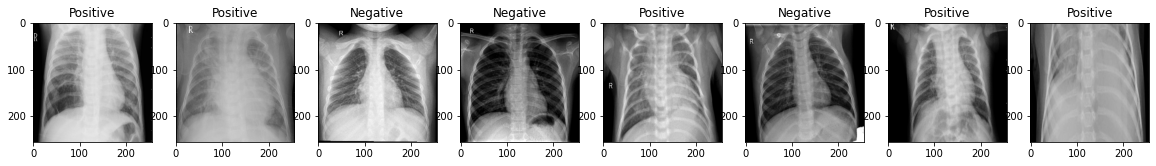

In [81]:
# Plot a sample batch for checking
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    label = label_titles[batch[1][idx]] #(1)
    ax[idx].title.set_text(label) # (2)
    
    # leave (3) & remove (1)(2) if takes too much memory
    #ax[idx].title.set_text(batch[1][idx]) # (3)

In [82]:
### 1.4. Data Normalization or Scaling

In [83]:
# For debug: Check current pixel values, it should be between 0-255
batch[0].min(), batch[0].max()

(0.0, 255.0)

In [84]:
# Data normalization, here pixel values get to be between 0-1
# Normalization is executed as the data is loaded in the pipeline
# In debugging, this code cannot be executed >1 time without loading dataset again
data = data.map(lambda x,y: (x/255, y))

# recheck pixel values, should be between 0-1
#batch[0].min(), batch[0].max()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


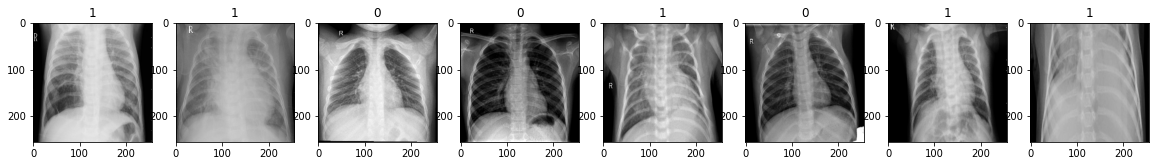

In [85]:
# Rechecking the data batch
# if samples are black the pizels are probably rescaled more than 1 time
# just reload the data
fig, ax = plt.subplots(ncols=8, figsize=(20,20))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx]) # (3)

In [87]:
### 1.5. Data Partitioning

In [88]:
# check number of batches in the dataset
len(data)

164

In [89]:
# Data partitioning: Trainng 70%, Validation 20%, Testing 10%
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1+2)

In [90]:
# recheck the data alocation. Last 2 values need to be equal
train_size, val_size, test_size, train_size+val_size+test_size, len(data)

(114, 32, 18, 164, 164)

In [91]:
# Executing the partitioning
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [92]:
# 2. Building the Deep Learning CNN Model

In [93]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [94]:
# Importing Keras Sequential API and the layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [95]:
# using the TensorFlow Keras Sequential API for modelling
model = Sequential()

In [96]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [97]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [99]:
# 3. Model Training

In [100]:
logdir='logs'

In [101]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [102]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
114/114 [==============================] - 79s 588ms/step - loss: 0.3276 - accuracy: 0.8517 - val_loss: 0.1461 - val_accuracy: 0.9404
Epoch 2/20
114/114 [==============================] - 68s 584ms/step - loss: 0.1067 - accuracy: 0.9627 - val_loss: 0.0994 - val_accuracy: 0.9668
Epoch 3/20
114/114 [==============================] - 58s 499ms/step - loss: 0.0814 - accuracy: 0.9726 - val_loss: 0.1045 - val_accuracy: 0.9658
Epoch 4/20
114/114 [==============================] - 68s 587ms/step - loss: 0.0646 - accuracy: 0.9767 - val_loss: 0.1088 - val_accuracy: 0.9678
Epoch 5/20
114/114 [==============================] - 68s 587ms/step - loss: 0.0509 - accuracy: 0.9803 - val_loss: 0.0975 - val_accuracy: 0.9707
Epoch 6/20
114/114 [==============================] - 58s 492ms/step - loss: 0.0490 - accuracy: 0.9816 - val_loss: 0.1494 - val_accuracy: 0.9521
Epoch 7/20
114/114 [==============================] - 67s 578ms/step - loss: 0.0359 - accuracy: 0.9866 - val_loss: 0.1088 - val_ac

In [103]:
# 4. Performance Plot

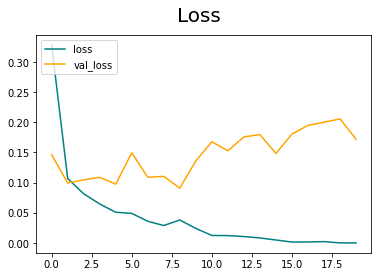

In [104]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

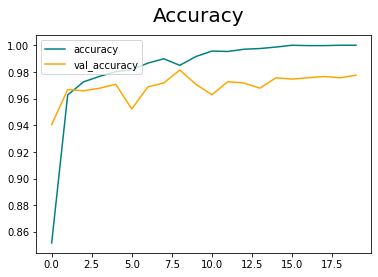

In [105]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [106]:
# 5. Evaluate CNN Model

In [107]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [108]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [109]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 289ms/step


In [110]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9848101, shape=(), dtype=float32) tf.Tensor(0.98730963, shape=(), dtype=float32) tf.Tensor(0.98039216, shape=(), dtype=float32)


In [111]:
# 10. Results and Testing

In [113]:
import cv2 

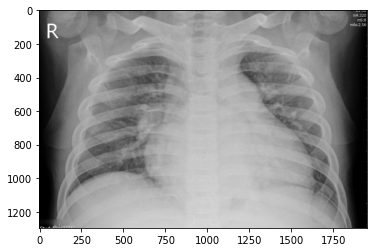

In [114]:
img = cv2.imread('/content/gdrive/MyDrive/cnnNet/data/chest_xray/test/PNEUMONIA/person21_virus_52.jpeg')
plt.imshow(img)
plt.show()

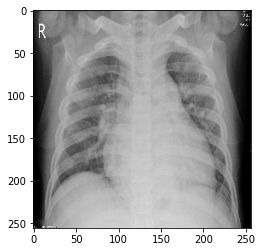

In [115]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [116]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 151ms/step


In [117]:
yhat

array([[1.]], dtype=float32)

In [118]:
if yhat > 0.5: 
    print(f'Predicted class is Positive')
else:
    print(f'Predicted class is Negative')

Predicted class is Positive


In [119]:
# 11. Save the Model

In [123]:
#from tensorflow.keras.models import load_model

In [124]:
#model.save(os.path.join('models','imageclassifier.h5'))

In [125]:
#new_model = load_model('imageclassifier.h5')

In [126]:
#new_model.predict(np.expand_dims(resize/255, 0))